****1. Import library****

In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
%matplotlib inline

****2. Data preprocessing****

In [24]:
# Read in track metadata with genre labels
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('datasets/echonest-metrics.json', precise_float=True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(tracks[['track_id', 'genre_top']], on='track_id')
# Inspect the resultant dataframe
print(echo_tracks.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB
None


In [48]:
echo_tracks.groupby('genre_top').genre_top.count()

genre_top
Hip-Hop     910
Rock       3892
Name: genre_top, dtype: int64

The number of Hip-Hop songs are far more than that of Rock songs, so the accuracy of these two genres varies, which means that our current model is only suitable for Hip-Hop songs.
Resampling methods are required.

In [59]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks.loc[echo_tracks.genre_top == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks.genre_top == 'Rock']

# I choose the oversampling methods here
hop_only = hop_only.sample(rock_only.shape[0], replace=True, random_state=123)

# concatenate the dataframes rock_only and hop_only
echo_tracks_bal = pd.concat([rock_only, hop_only])

In [60]:
echo_tracks_bal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7784 entries, 4 to 2750
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          7784 non-null   int64  
 1   acousticness      7784 non-null   float64
 2   danceability      7784 non-null   float64
 3   energy            7784 non-null   float64
 4   instrumentalness  7784 non-null   float64
 5   liveness          7784 non-null   float64
 6   speechiness       7784 non-null   float64
 7   tempo             7784 non-null   float64
 8   valence           7784 non-null   float64
 9   genre_top         7784 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 668.9+ KB


In [61]:
# Create a correlation matrix
corr_metrics = echo_tracks_bal.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.328082,0.066177,0.193593,-0.225482,0.077084,-0.025706,-0.034402,-0.011693
acousticness,-0.328082,1.000000,-0.125691,-0.229314,0.104775,-0.034193,0.128767,0.018133,-0.008556
danceability,0.066177,-0.125691,1.000000,-0.239903,-0.273475,-0.095201,0.284710,-0.225044,0.470436
energy,0.193593,-0.229314,-0.239903,1.000000,0.021298,0.132374,-0.119099,0.134179,-0.018821
instrumentalness,-0.225482,0.104775,-0.273475,0.021298,1.000000,-0.137854,-0.453138,0.036731,-0.255288
liveness,0.077084,-0.034193,-0.095201,0.132374,-0.137854,1.000000,0.059255,-0.018512,-0.065762
speechiness,-0.025706,0.128767,0.284710,-0.119099,-0.453138,0.059255,1.000000,0.017230,0.223397
tempo,-0.034402,0.018133,-0.225044,0.134179,0.036731,-0.018512,0.017230,1.000000,0.012429
valence,-0.011693,-0.008556,0.470436,-0.018821,-0.255288,-0.065762,0.223397,0.012429,1.000000


 There is no obvious correlationships among features

In [62]:
# Create features
features = echo_tracks_bal.drop(columns=['genre_top','track_id'])

# Create labels
labels = echo_tracks_bal['genre_top']

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(
                    features, labels, random_state=10)

In [63]:
# Scale the features and set the values to a new variable
scaler = StandardScaler()

# Scale train_features and test_features
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.fit_transform(test_features)

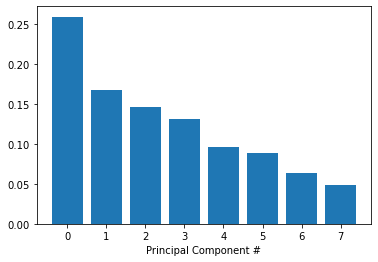

In [64]:
# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_
# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')
plt.show()

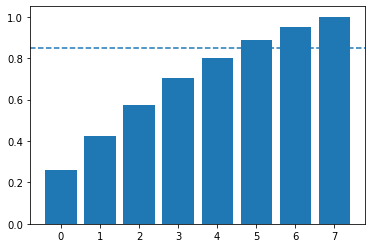

In [65]:
# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
plt.bar(range(pca.n_components_), cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')
plt.show()

The first 6 features can explain up to 85%  of the variance, so we can use only 6 features to reduce the dimensionality.

In [66]:
# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components=6, random_state=10)

# Fit and transform the scaled training features using pca
train_pca = pca.fit_transform(scaled_train_features)

# Fit and transform the scaled test features using pca
test_pca = pca.fit_transform(scaled_test_features)

****3. Choose models and evaluate them****

Decision tree and Logistic regression are common models to predict our data here.

In [67]:
# Train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_pca)

In [68]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state=10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

In [69]:
# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels,pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.81      0.61      0.69       952
        Rock       0.70      0.87      0.77       994

    accuracy                           0.74      1946
   macro avg       0.75      0.74      0.73      1946
weighted avg       0.75      0.74      0.73      1946

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.80      0.82      0.81       952
        Rock       0.82      0.80      0.81       994

    accuracy                           0.81      1946
   macro avg       0.81      0.81      0.81      1946
weighted avg       0.81      0.81      0.81      1946



To eliminate the effect of splitting training datasets and test datasets randomly, the K-fold CV method is applied here.

In [70]:
tree_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                      ("tree", DecisionTreeClassifier(random_state=10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                        ("logreg", LogisticRegression(random_state=10))])

# Set up our K-fold cross-validation
kf = KFold(10)

# Train our models using KFold cv
tree_score = cross_val_score(tree_pipe, features, labels, cv=kf)
logit_score = cross_val_score(logreg_pipe, features, labels, cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.9343661209579219 Logistic Regression: 0.7657718187248169


It shows that Decision Tree is much more accurate in predicting the genre of songs by our 6 features.